
# <font color='green'>sentiment Analysis</font> ![title](./resources/img/sent_twitter.png)

## <font color='red'>Learning Data</font>
***

#### Importer les libreries

Reportez-vous aux pages Web pour les bibliothèques individuelles
* [Pandas](http://pandas.pydata.org/), pour charger et gérer les données
* [Matplotlib](http://matplotlib.org/), pour la visualisation
* [numpy](http://www.numpy.org/) pour la représentation de tableau et la manipulation
* [re](https://docs.python.org/3/library/re.html) pour les expressions régulières
* [nltk](http://www.nltk.org/) pour le prétraitement

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk

%matplotlib inline

#### Reading the dataset

In [2]:
df = pd.read_csv('./data/train/downloaded_cleansed_B.tsv', 
                 sep= '\t', header=None)
df.head()

,0,1,2,3
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,263405084770172928,591166521,negative,Not Available
2,262163168678248449,35266263,negative,Not Available
3,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
4,262682041215234048,254373818,neutral,Not Available


Notez que certains tweets ne sont pas disponibles. Nous allons les rejeter car cela n'aidera pas dans l'analyse des sentiments

#### Supprimer tous les tweets "NOT AVAILABLE"

In [3]:
df = df[df[3] != "Not Available"]
df.head()

,0,1,2,3
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
3,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
6,264105751826538497,147088367,positive,with J Davlar 11th. Main rivals are team Polan...
7,264094586689953794,332474633,negative,"Talking about ACT's &amp;&amp; SAT's, deciding..."
9,254941790757601280,557103111,negative,"They may have a SuperBowl in Dallas, but Dalla..."


In [4]:
df.shape

(7205, 4)

#### <font color='blue'>Les Tweets d'entrainement sont trop limité : juste 7205 tweets ...</font>

#### Tracer les données 

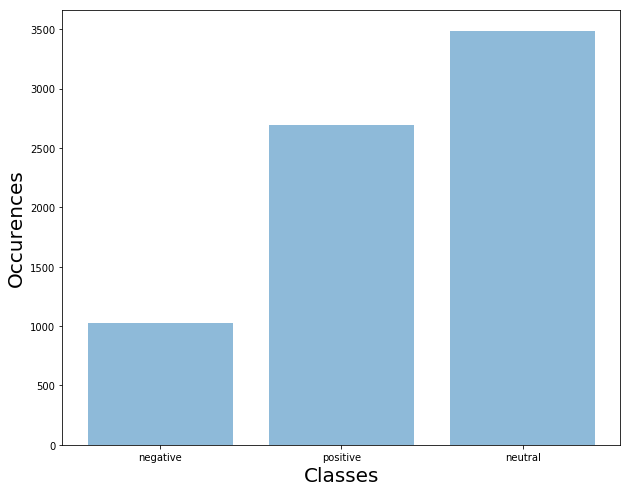

In [5]:
# calculer le nombre total d'occurrences de chaque classe
y = [len(df[df[2] == i]) for i in ['negative', 'positive', 'neutral']]
# X axis
objects = ['negative', 'positive', 'neutral']
x_pos = range(len(objects))

# Tracer diagramme
plt.figure(figsize=(10,8))
plt.bar(x_pos, y, alpha=0.5)
plt.xticks(x_pos, objects)
plt.ylabel('Occurences').set_size(20)
plt.xlabel('Classes').set_size(20)

#### Interprétation
À partir du graphique ci-dessus, nous pouvons clairement noter que la classe «négative» a le moins d'échantillons dans les données par rapport à «positive» et «neutre». Par conséquent, les données semblent être déséquilibrées et underfit la classe «négative».

In [6]:
raw_tweets = list(df[3])

***
## <font color='red'>Pré-traiter les tweets</font>
https://nlp.stanford.edu/IR-book/html/htmledition/determining-the-vocabulary-of-terms-1.html
***

#### Supprimer slangs des tweets


In [7]:
def loadSlangs(filename):
    slangs={}
    fi=open(filename,'r')
    line=fi.readline()
    while line:
        l=line.split(r',%,')
        if len(l) == 2:
            slangs[l[0]]=l[1][:-2]
        line=fi.readline()
    fi.close()
    return slangs

def replaceSlangs(tweet,slangs):
    result=''
    tweet = tweet.lower()
    words=tweet.split()
    for w in words:
        if w in slangs.keys():
            result=result+slangs[w]+" "
        else:
            result=result+w+" "
    return result

slangs = loadSlangs('./resources/internetSlangs.txt')

#### création d'un fichier manuellement avec les mots parasites "firasFeatures.txt"
* Supprimer les 7.000 mots les moins fréquants
* nombre de features passe de 74.414 à 66.156 
* laisser juste les mots avec une occurance supperieur à 2
* passage d'accuracy test de 64.69% à 64.85%

In [8]:
slangs = loadSlangs('./resources/firasFeatures.txt')
raw_tweets = [replaceSlangs(tweet, slangs) for tweet in raw_tweets]

* Appliquer des techniques de prétraitement standard

* https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html
* https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html


#### Utiliser NRC emoticon lexicon

* Nous remplacerons l'émoticône par sa signification associée.

In [9]:
from nltk.tokenize import TweetTokenizer

TT = TweetTokenizer()

def emoticondictionary(filename):
    emo_scores = {'Positive': 'positive', 'Extremely-Positive': 'positive', 
                  'Negative': 'negative','Extremely-Negative': 'negative',
                  'Neutral': 'neutral'}
    emo_score_list = {}
    fi = open(filename,"r")
    l = fi.readline()
    while l:
        l = l.replace("\xc2\xa0"," ")
        li = l.split(" ")
        l2 = li[:-1]
        l2.append(li[len(li) - 1].split("\t")[0])
        sentiment=li[len(li) - 1].split("\t")[1][:-1]
        score=emo_scores[sentiment]
        l2.append(score)
        for i in range(0,len(l2)-1):
            emo_score_list[l2[i]]=l2[len(l2)-1]
        l=fi.readline()
    return emo_score_list

dict = emoticondictionary('./resources/emoticon.txt')

# substititue emoticon with its associated sentiment
def subsEmoticon(tweet,d):
    l = TT.tokenize(tweet)
    tweet = [d[i] if i in d.keys() else i for i in l]
    return tweet

raw_tweets = [subsEmoticon(tweet, dict) for tweet in raw_tweets]

print(":D X3 :|")
subsEmoticon(":D X3 :|", dict)

:D X3 :|


['positive', 'positive', 'neutral']

In [10]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

mmer = WordNetLemmatizer()

# lemmatizer les tweets
def _lemma(tweet):
    return ' '.join([mmer.lemmatize(word) for word in tweet])

stemmed_tweets = [_lemma(tweet) for tweet in raw_tweets]


def preprocess(tweet):
    # supprimer les symboles et les URI
    tweet =  ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)",
                             '',tweet).split())
    #Convertir @username à AT_USER
    tweet = re.sub('@[^\s]+','at_user',tweet)
    # supprimer les hashtags
    tweet = re.sub(r'#\s', '', tweet)
    # supprimer les nombres
    tweet = re.sub('[0-9]', '', tweet)
    # supprimer les espaces en surplus
    tweet = re.sub('[\s]+', ' ', tweet)
    # remplacer l'occurrence de 2 ou plusieurs caractères dans un mot, par ex. loooong -> loong
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)
    return tweet

preprocessed_tweets = [preprocess(tweet) for tweet in stemmed_tweets]

#### Supprimer les stopwords
https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html

In [11]:
# importer stopwords 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.update('j', 'im')

# supprimer les stopwords
def rem_stop(tweet):
    words = tweet.split()
    tweet = ' '.join([word for word in words if word not in stop_words])
    return tweet

final_tweets = [rem_stop(tweet) for tweet in preprocessed_tweets]

#len(final_tweets)

print("\nComparer tweets avant/après")
df['final_tweets'] = final_tweets
df[[3, 'final_tweets']].head(10)


Comparer tweets avant/après


,3,final_tweets
0,Gas by my house hit $3.39!!!! I'm going to Cha...,gas house hit im going chapel hill sat
3,Iranian general says Israel's Iron Dome can't ...,iranian general say israels iron dome cant dea...
6,with J Davlar 11th. Main rivals are team Polan...,davlar th main rival team poland hopefully mak...
7,"Talking about ACT's &amp;&amp; SAT's, deciding...",talking acts sats deciding want go college app...
9,"They may have a SuperBowl in Dallas, but Dalla...",may superbowl dallas dallas aint winning super...
10,Im bringing the monster load of candy tomorrow...,im bringing monster load candy tomorrow hope d...
11,"Apple software, retail chiefs out in overhaul:...",apple software retail overhaul san francisco a...
12,@oluoch @victor_otti @kunjand I just watched i...,otti watched sridevis comeback u remember sun ...
14,#Livewire Nadal confirmed for Mexican Open in ...,livewire nadal confirmed mexican open february...
15,@MsSheLahY I didnt want to just pop up... but ...,didnt want pop yep chapel hill next wednesday ...


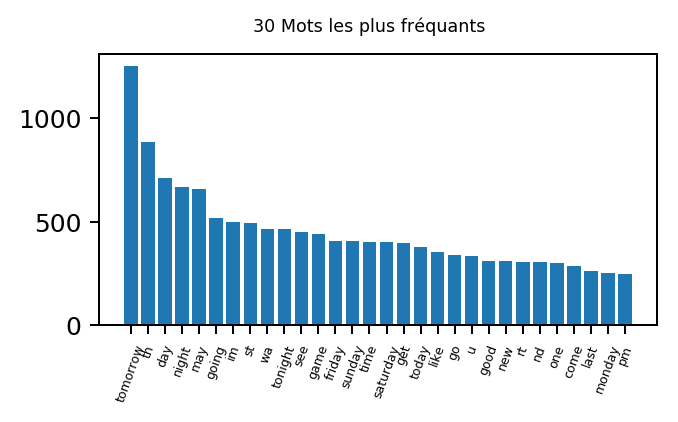

In [12]:
import collections
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import numpy as np

word_list = [word for line in final_tweets for word in line.split()]
counter = collections.Counter(word_list)

labels = [item[0] for item in counter.most_common(30)]
number = [item[1] for item in counter.most_common(30)]
nbars = len(counter.most_common(30))

plt.figure(figsize=(4,2), dpi=180)
plt.xticks(rotation=70, fontsize=5)
plt.bar(np.arange(nbars), number, tick_label=labels)
plt.suptitle("30 Mots les plus fréquants",fontsize=7)
plt.show()

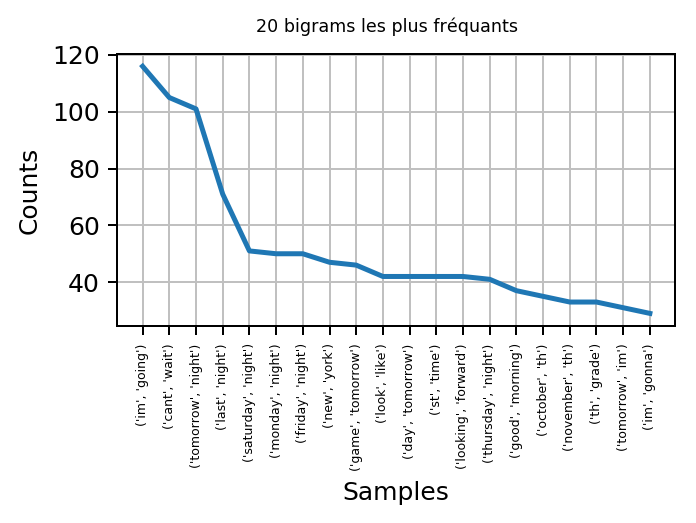

In [13]:
def find_bigrams(input_list):
  bigram_list = []
  for i in range(len(input_list)-1):
      bigram_list.append((input_list[i], input_list[i+1]))
  return bigram_list

bigram_list = find_bigrams(word_list)
freq_bi = nltk.FreqDist(bigram_list)


freq_bi.most_common(30)
plt.figure(figsize=(4,2), dpi=180)
plt.xticks(fontsize=5)
plt.suptitle("20 bigrams les plus fréquants",fontsize=7)
freq_bi.plot(20)

***
## <font color='red'>Lexicon Classification</font>
***

#### Utiliser MPQA Lexicon

In [14]:
from nltk.tokenize import TweetTokenizer

TT = TweetTokenizer()

def MPQAdictionary(filename):
    MPQA_scores = {'priorpolarity=positive\n': 'positive','priorpolarity=negative\n': 'negative',
                  'priorpolarity=neutral\n': 'neutral', 'priorpolarity=both\n': 'neutral'}
    MPQA_score_list = {}
    fi = open(filename,"r")
    line = fi.readline()
    while line: 
        line = line.replace("\xc2\xa0"," ")
        li = line.split(" ")
        l2 = li[:-1]
        l2.append(li[len(li) - 1].split("\t")[0])
        sentiment=li[1]
        score=MPQA_scores[sentiment]
        l2.append(score)
        for i in range(0,len(l2)-1):
            MPQA_score_list[l2[i]]=l2[len(l2)-1]
        line=fi.readline()
    #print(MPQA_score_list)
    return MPQA_score_list #marche

dictionary = MPQAdictionary('./resources/mpqa/mpqa.txt')

def subsMPQA(tweet,d):
    l = TT.tokenize(tweet)
    #print(l)
    tweet = [d[i] if i in d.keys() else i for i in l]
    return tweet

raw_tweets_MPQA = [subsMPQA(tweet,dictionary) for tweet in final_tweets]
#print (raw_tweets_MPQA)
    
subsMPQA("surprise happy abandoned", dictionary)

['neutral', 'positive', 'negative']

#### Utiliser Bing Liu Lexicon

In [15]:
import os

TT = TweetTokenizer()
mmer = WordNetLemmatizer()

# lemmatizer les tweets
def _lemma(tweet):
    return ' '.join([mmer.lemmatize(word) for word in tweet])

stemmed_tweets_MPQA = [_lemma(tweet) for tweet in raw_tweets_MPQA]
#print(stemmed_tweets_MPQA)

ENGLISH_OPINION_LEXICON_LOCATION = os.path.join('resources/opinion-lexicon-English')
POS_WORDS_FILE = os.path.join(ENGLISH_OPINION_LEXICON_LOCATION, 'positive-words.txt')
NEG_WORDS_FILE = os.path.join(ENGLISH_OPINION_LEXICON_LOCATION, 'negative-words.txt')

pos_words = []
neg_words = []

for pos_word in open(POS_WORDS_FILE, 'r').readlines()[35:]:
    pos_words.append(pos_word.rstrip())

for neg_word in open(NEG_WORDS_FILE, 'r', errors='ignore').readlines()[35:]:
    neg_words.append(neg_word.rstrip())

print ("Number of negative words %d" % len(pos_words))
print ("Number of negative words %d" % len(neg_words))
#print(pos_words)

def subsBINGP(tweet, pos_words):
    l = TT.tokenize(tweet)
    tweet = ['positive' if i in pos_words else i for i in l]
    return tweet

def subsBINGN(tweet, neg_words):
    l = TT.tokenize(tweet)
    tweet = ['negative' if i in neg_words else i for i in l]
    return tweet

raw_tweets_bing = [subsBINGP(tweet, pos_words) for tweet in stemmed_tweets_MPQA]
raw_tweets_bing = [subsBINGN(tweet, neg_words) for tweet in stemmed_tweets_MPQA]

stemmed_final = [_lemma(tweet) for tweet in raw_tweets_bing]
#print(stemmed_final)

#print(raw_tweets_bing)
subsBINGP("enjoy firas extraordinarily", pos_words) #Ca marche

Number of negative words 2006
Number of negative words 4783


['positive', 'firas', 'positive']

#### [Afinn](https://pypi.python.org/pypi/afinn)

In [16]:
def loadAfinn(filename):
    f=open(filename,'r')
    afinn={}
    line=f.readline()
    nbr=0
    while line:
        nbr+=1
        l=line[:-1].split('\t')
        afinn[l[0]]=float(l[1])/4 # normalisation
        line=f.readline()

    return afinn

afinn = loadAfinn('./resources/afinn.txt')
#print(afinn)

def afinnPolarity(tweet,afinn):
    p=0.0
    nbr=0
    for w in tweet:
        if w in afinn.keys():
            nbr+=1
            p+=afinn[w]
    if (nbr != 0):
        return p/nbr
    else:
        return 0.0

#### SemEval2015 English lexicon 

In [17]:
def loadSemEval(filename):
    f=open(filename,'r')
    lexicon={}
    line=f.readline()
    nbr=0
    while line:
        nbr+=1
        l=line[:-1].split('\t')
        lexicon[l[1]]=float(l[0])/4 # normalisation
        line=f.readline()

    return lexicon

EnglishLexicon = loadSemEval('./resources/SemEval2015-English-Twitter-Lexicon.txt')

def SemEvalLexiconPolarity(tweet,EnglishLexicon):
    p=0.0
    nbr=0
    for w in tweet:
        if w in EnglishLexicon.keys():
            nbr+=1
            p+=EnglishLexicon[w]
    if (nbr != 0):
        return p/nbr
    else:
        return 0.0

#### SentiWordNet

In [18]:
def loadSentiWordnet(filename): 
    output={}
    print ("Ouverture du fichier SentiWordnet ...")
    fi=open(filename,"r")
    line=fi.readline() # ignorer header
    line=fi.readline()
    print ("Chargement...")

    while line:
        l=line.split('\t')
        try:
            
            sentence=l[4]
            new = [word for word in sentence.split() if (word[-2] == "#" and word[-1].isdigit())]
            pos=abs(float(l[2]))
            neg=abs(float(l[3]))
            neu=float(pos-neg)
        except:
            line=fi.readline()
            continue

        for w in new:
            output[(w[:-2])]=neu
        line=fi.readline()
    fi.close()
    return output

sentiWordnet = loadSentiWordnet('./resources/sentiWordnetBig.csv')

def WordnetPolarity(tweet,sentiWordnet):
    p=0.0
    nbr=0
    for w in tweet:
        if w in sentiWordnet.keys():
            nbr+=1
            p+=sentiWordnet[w]
    if (nbr != 0):
        return p/nbr
    else:
        return 0.0

Ouverture du fichier SentiWordnet ...
Chargement...


### Calcul polarité

In [19]:
# Combiner le score de 5 lexicons :
# Afinn / MPQA / Bing Liu / WordNet / SemEval-Lexicon

final_score_tweets = []

for tw in raw_tweets_bing:
    
    AfinnScore = afinnPolarity(tw,afinn)
    WordnetScore = WordnetPolarity(tw,sentiWordnet)
    SemEvalLexicon = SemEvalLexiconPolarity(tw,EnglishLexicon)
    
    score_Bing_MPQA = 0
    for i in tw:
        if (i == 'positive'):
           score_Bing_MPQA = score_Bing_MPQA + 1
        if (i == 'negative'):
           score_Bing_MPQA = score_Bing_MPQA - 1
        
    final_score_tweets.append(score_Bing_MPQA + AfinnScore + WordnetScore + SemEvalLexicon)

#final_score_tweets #ma liste des score
df['score_tweets_lexicon'] = final_score_tweets
df[['score_tweets_lexicon', 'final_tweets' ,2]].head(25)

,score_tweets_lexicon,final_tweets,2
0,-0.008464,gas house hit im going chapel hill sat,positive
3,2.578367,iranian general say israels iron dome cant dea...,negative
6,1.231125,davlar th main rival team poland hopefully mak...,positive
7,0.030167,talking acts sats deciding want go college app...,negative
9,0.979167,may superbowl dallas dallas aint winning super...,negative
10,0.072839,im bringing monster load candy tomorrow hope d...,neutral
11,-0.072750,apple software retail overhaul san francisco a...,neutral
12,1.681833,otti watched sridevis comeback u remember sun ...,positive
14,1.710333,livewire nadal confirmed mexican open february...,neutral
15,2.365178,didnt want pop yep chapel hill next wednesday ...,positive


##### En comparant les scores avec les vrais résultats, on peut conclure que l'utilisation du lexicon ne donne pas des très bons résultats... Il faut rajouter des scores pour les bi-grams.
##### Il faut par la suite combiner la classification lexicon/machine learning!

***

***
## <font color='red'>Entraîner le modèle</font>
***

#### Créer un vecteur de features
* Voir [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) pour plus de détails

In [20]:
# Utiliser count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Utiliser bigram en créant le vecteur
vectorizer = CountVectorizer(analyzer='word', preprocessor=None, stop_words=None, 
                             tokenizer=None,  ngram_range=(1,2))

#features = vectorizer.fit_transform(final_tweets) # (7205, 66156)

features = vectorizer.fit_transform(final_tweets)
features.shape

(7205, 66157)

#### Mettre des étiquettes pour entrainer

In [21]:
labels = df[2]
mapper = {'positive': 1, 'negative': -1, 'neutral': 0}

labels = labels.map(mapper)
labels.shape

(7205,)

### Features selection

##### Pour installer xgboost : [Tuto](https://isaacchanghau.github.io/2017/06/20/Install-XGBoost-on-Mac-OS-X/) 

![title](./resources/img/Filter.png)

In [22]:
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from numpy import sort

# fit model on all training data
model = XGBClassifier()
model.fit(features, labels)

thresholds = sort(model.feature_importances_)
thresholds
#len(thresholds)

array([ 0.        ,  0.        ,  0.        , ...,  0.02154626,
        0.02217997,  0.03422053], dtype=float32)

In [23]:
## PREND 2h pour l'execution

#for thresh in thresholds:
    # select features using threshold
#    selection = SelectFromModel(model, threshold=thresh, prefit=True)    
#    select_X_train = selection.transform(features)

In [24]:
#select_X_train.shape

#### Importer SVM

http://scikit-learn.org/stable/modules/svm.html

Pour un aperçu mathématique,
https://docs.opencv.org/2.4/doc/tutorials/ml/introduction_to_svm/introduction_to_svm.html

#### Obtenir le paramètre de régularisation optimal en utilisant handout method

Max value of 0.999 occured at C=1.300


Text(0,0.5,'precision score')

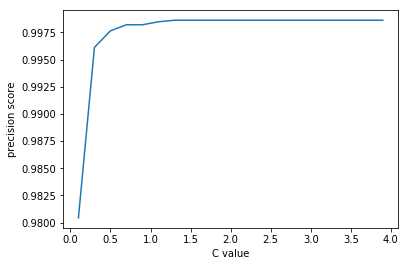

In [25]:
from sklearn import metrics
from sklearn.svm import SVC
import numpy as np

KERNEL = 'linear'
C_start = 0.1
C_end = 4.0
C_inc = 0.20

C_values, precision_scores = [], []

C_val = C_start
best_precision_score = 0
while (C_val < C_end):
    C_values.append(C_val)
    svc_model_loop = SVC(C=C_val, kernel=KERNEL, random_state=42)
    svc_model_loop.fit(features, labels.ravel())
    svc_predict_loop_test = svc_model_loop.predict(features)
    
    precision_score = metrics.precision_score(labels, svc_predict_loop_test,
                                        average='micro')
    precision_scores.append(precision_score)
    if (precision_score > best_precision_score):
        best_precision_score = precision_score
        best_lr_predict_test = svc_predict_loop_test
        
    C_val = C_val + C_inc

best_score_C_val = C_values[precision_scores.index(best_precision_score)]
print("Max value of {0:.3f} occured at C={1:.3f}".format(best_precision_score,
                                                             best_score_C_val))

%matplotlib inline 
plt.plot(C_values, precision_scores, "-")
plt.xlabel("C value")
plt.ylabel("precision score")

In [26]:
classifier = SVC(kernel=KERNEL, C=best_score_C_val)
classifier.fit(features, labels)

SVC(C=1.2999999999999998, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Prédiction sur les données d'entraînement

In [27]:
from sklearn import metrics

nb_predict_train = classifier.predict(features)

#check accuracy
print("Accuracy: {:0.4f}".format(metrics.accuracy_score(labels, nb_predict_train)))

Accuracy: 0.9986


In [28]:
#print confusion matrix
print("{}".format(metrics.confusion_matrix(labels, nb_predict_train, 
                                           labels=[1,-1, 0])))

print("{}".format(metrics.classification_report(labels, nb_predict_train, 
                                                labels=[1, -1, 0])))

[[2684    1    7]
 [   0 1022    2]
 [   0    0 3489]]
             precision    recall  f1-score   support

          1       1.00      1.00      1.00      2692
         -1       1.00      1.00      1.00      1024
          0       1.00      1.00      1.00      3489

avg / total       1.00      1.00      1.00      7205



### Prédire en utilisant le modèle
***

#### Importer les données de test

In [29]:
t_df = pd.read_csv('./data/test/actual/test_B_labeled.tsv', 
                   sep='\t', header=None)
t_df.shape

(8902, 4)

In [30]:
t_df = t_df[t_df[3] != 'Not Available']
#t_df = t_df[t_df[2] != 'neutral']
t_df.shape

(7584, 4)

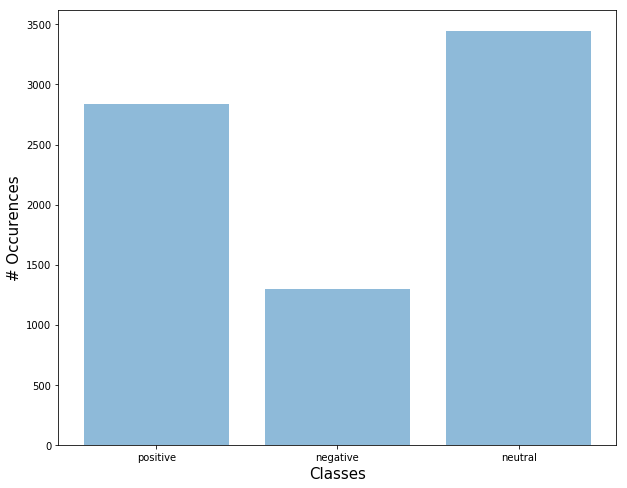

In [31]:
# le diagramme à barres pour l'ensemble de données de test

y = [len(t_df[t_df[2] == i]) for i in ['positive', 'negative', 'neutral']]
x = ['positive', 'negative', 'neutral']
x_pos = range(len(x))

plt.figure(figsize=(10,8))
plt.bar(x_pos, y, alpha=0.5)
plt.xticks(x_pos, x)
plt.ylabel('# Occurences').set_size(15)
plt.xlabel('Classes').set_size(15)

#### Pré-traiter les tweets de l'ensemble de données de test

In [32]:
raw_tweets_test = t_df[3]
raw_tweets_test = [replaceSlangs(tweet, slangs) for tweet in raw_tweets_test]
raw_tweets_test = [subsEmoticon(tweet, dict) for tweet in raw_tweets_test]
stemmed_tweets_test = [_lemma(tweet) for tweet in raw_tweets_test]
preprocessed_tweets_test = [preprocess(tweet) for tweet in stemmed_tweets_test]
final_tweets_test = [rem_stop(tweet) for tweet in preprocessed_tweets_test]

## ToDo ## partie ajouter pour les lexicons
#raw_tweets_MPQA_test = [subsMPQA(tweet,dictionary) for tweet in final_tweets_test]
#stemmed_tweets_MPQA_test = [_lemma(tweet) for tweet in raw_tweets_MPQA_test]
#raw_tweets_bing_test = [subsBINGP(tweet, pos_words) for tweet in stemmed_tweets_MPQA_test]
#raw_tweets_bing_test = [subsBINGN(tweet, neg_words) for tweet in stemmed_tweets_MPQA_test]
#stemmed_final = [_lemma(tweet) for tweet in raw_tweets_bing_test]

# final_tweets
t_df[3] = final_tweets_test

In [33]:
t_df.head()

,0,1,2,3
2,282031301962395648,T14111200,neutral,dec st know end world baby boom shit
3,11975,SM112166,negative,yar quite many guess lor got ask bring thk dar...
4,136592,LJ112295,negative,yeah thin lizzy hate informercial
5,253421252956545024,T13114433,neutral,mt syria deir ezzor ali bashar altheeb wa mart...
6,220880422320603137,T14114138,negative,hate life cant see roskilde festival saturday ...


#### Créer le vecteur de features 

In [34]:
#test_features = vectorizer.transform(stemmed_final)
test_features = vectorizer.transform(final_tweets_test)
test_features.shape

(7584, 66157)

#### Obtenir les étiquettes à partir d'un ensemble de données de test

In [35]:
actual_labels = t_df[2]
actual_labels = actual_labels.map(mapper)
actual_labels.shape

(7584,)

#### Prédire les étiquettes en utilisant le modèle

In [36]:
predicted_labels = classifier.predict(test_features)

### Évaluer le modèle
***

#### Évaluer l'accuracy (exactitude)

In [37]:
print('Accuracy: {:0.2f}%'.format(metrics.accuracy_score(actual_labels, 
                                                         predicted_labels) * 100))

Accuracy: 64.86%


#### Accuracy d'une validation croisée 10 fois sur les données tests

In [38]:
from sklearn import model_selection
scores = model_selection.cross_val_score(classifier, test_features, actual_labels, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.64 (+/- 0.04)


In [39]:
#from sklearn import model_selection
        
#scores = model_selection.cross_val_score(classifier, actual_labels, predicted_labels, cv=10, scoring='accuracy')
#print("Accuracy cross val X10: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [40]:
# dessiner le rapport de classification
print('{}'.format(metrics.classification_report(actual_labels, 
                                           predicted_labels)))

             precision    recall  f1-score   support

         -1       0.64      0.26      0.37      1296
          0       0.62      0.84      0.71      3448
          1       0.71      0.59      0.64      2840

avg / total       0.66      0.65      0.63      7584



Voir [matrice de confusion](https://fr.wikipedia.org/wiki/Matrice_de_confusion) pour plus de détails


In [41]:
# matrice de confusion
print('{}\n'.format(metrics.confusion_matrix(actual_labels, predicted_labels, labels=[1,-1,0])))
print("\x1b[31m\" micro f1 score \"\x1b[0m")
print('{}\n'.format(metrics.f1_score(actual_labels, predicted_labels, average='macro')))
print("\x1b[31m\" macro f1 score \"\x1b[0m")
print('{}\n'.format(metrics.f1_score(actual_labels, predicted_labels, average='micro')))

[[1677  101 1062]
 [ 233  332  731]
 [ 452   86 2910]]

" micro f1 score "
0.5748716860420309

" macro f1 score "
0.6486023206751055



### Comparaison avec les 5 meilleurs équipes du subtask B

Nous comparons notre f-score moyen avec les autres équipes du workshop. Les résultats sont tirés du document ci-joint:
[Final report SemEval 2014 Subtask 9](http://www.aclweb.org/anthology/S14-2009)

|Team|Accuracy (Macro Averaged)| Accuracy (Micro Averaged)|
|----|-------------------------|--------------------------|
|TeamX|65.63%|69.99%|
|coooolll|63.23%|70.51%|
|RTRGO|63.08%|70.15%|
|NRC-Canada|67.62%|71.37%|
|TUGAS|63.89%|68.84%|
|**_MOI_**|_57.48%_|_64.86%_|
| | |***classement : 23 / 50***|
 